In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import torch.nn as nn
import os
import torch
%matplotlib inline
from tqdm import tqdm
import sys

sys.path.append('../')
from utils import project_root, get_data_labels, BrainGraphDataset
root = project_root()

def compute_regression(model_type='random_forest', leave_one_out=True, use_graph=True, mode='psilo_schaefer_before'):   
    torch.manual_seed(0)
    categories = ['patient_n','condition','bdi_before']

    data_labels = get_data_labels()
    data_labels = data_labels[categories]

    annotations = 'annotations.csv'

    data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
    data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
    data_labels['condition'] = data_labels['condition'].astype('float64')

    dataroot = f'fc_matrices/{mode}/'

    dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                                annotations_file=os.path.join(root, annotations),
                               transform=None, extra_data=data_labels, labelled=True, setting='upper_triangular_and_baseline')
    ground = []
    predicted = []
    labels = []
    print('Training started.')

    if model_type == 'random_forest':
        regressor = RandomForestRegressor(random_state=0, n_estimators=100)
    elif model_type == 'ridge':
        regressor = Ridge(alpha=0.1)
    elif model_type == 'lasso':
        regressor = Lasso(alpha=0.1)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    if leave_one_out:
        for i in tqdm(range(len(dataset))):
            training_dataset = torch.utils.data.Subset(dataset, [j for j in range(len(dataset)) if not(j == i)])
            test_dataset = torch.utils.data.Subset(dataset, [i])

            training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=len(training_dataset),
                                                        shuffle=False, num_workers=1)

            test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset),
                                                        shuffle=False, num_workers=1)
            
            (graph, base), y = next(iter(training_dataloader))
            X = torch.cat([graph, base], dim=1) if use_graph else base
            regressor.fit(X, y)

            (graph, base), y = next(iter(test_dataloader))
            X = torch.cat([graph, base], dim=1) if use_graph else base
            predictions = regressor.predict(X)

            ground.append(y[-1])
            predicted.append(predictions)
            labels.append(X[0,-2])
            
    else:
        training_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

        for (graph, base), y in training_dataloader:
            X = torch.cat([graph, base], dim=1) if use_graph else base
            regressor.fit(X, y)

            predictions = regressor.predict(X)

            ground = y
            predicted = predictions

    print('Training complete.')
    
    a1 =  torch.tensor(ground)
    a2 = torch.tensor(predicted)
    loss = nn.L1Loss(reduction='mean')(a1, a2.view(a1.shape))
    
    from sklearn.metrics import r2_score
    r2 = r2_score(ground, predicted)

    return ground, predicted, data_labels, loss, r2


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import datasets, linear_model

def plot_ground_vs_pred(ground, predicted, labels, atlas='schaefer', mode=''):

    escit_pred = []
    escit_ground = []

    psilo_pred = []
    psilo_ground = []

    # for i in range(len(ground)):

    for i, n in enumerate(labels['patient_n']):
        if labels.loc[labels['patient_n']==n]['condition'].item() == 1:
            psilo_pred.append(predicted[i].item())
            psilo_ground.append(ground[i].item())
        else:
            escit_pred.append(predicted[i].item())
            escit_ground.append(ground[i].item())

    escit_pred = np.array(escit_pred)
    escit_ground = np.array(escit_ground)
    psilo_pred = np.array(psilo_pred)
    psilo_ground = np.array(psilo_ground)

    # plt.scatter(escit_ground, escit_pred)
    plt.scatter(psilo_ground, psilo_pred, label='Psilocybin')
    plt.scatter(escit_ground, escit_pred, label='Escitalopram')

    regr = linear_model.LinearRegression()

    psilo_ground = np.reshape(psilo_ground, (-1, 1))
    regr.fit(psilo_ground, psilo_pred)

    lbf = regr.predict([[0],[50]])
    plt.plot([0,50], lbf)

    escit_ground = np.reshape(escit_ground, (-1, 1))
    regr.fit(escit_ground, escit_pred)

    lbf = regr.predict([[0],[50]])
    plt.plot([0,50], lbf)

    # plt.plot(ground, predicted)
    plt.title(f'Ground BDI vs Predicted BDI for Psilocybin and Escitalopram ({mode})')
    plt.xlabel('Ground BDI')
    plt.ylabel('Predicted BDI')
    plt.legend()
    plt.xlim([0,50])
    plt.ylim([0,50])
    plt.savefig(os.path.join(root, f'{atlas}_{mode}.png')) 
    plt.show()


In [8]:
forest_ground, forest_predicted, forest_data_labels, forest_loss, forest_r2 = compute_regression(model_type='random_forest')
ridge_ground, ridge_predicted, ridge_data_labels, ridge_loss, ridge_r2 = compute_regression(model_type='ridge')
lasso_ground, lasso_predicted, lasso_data_labels, lasso_loss, lasso_r2 = compute_regression(model_type='lasso')

Training started.


100%|██████████| 42/42 [02:42<00:00,  3.87s/it]


Training complete.
Training started.


100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Training complete.
Training started.


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]

Training complete.


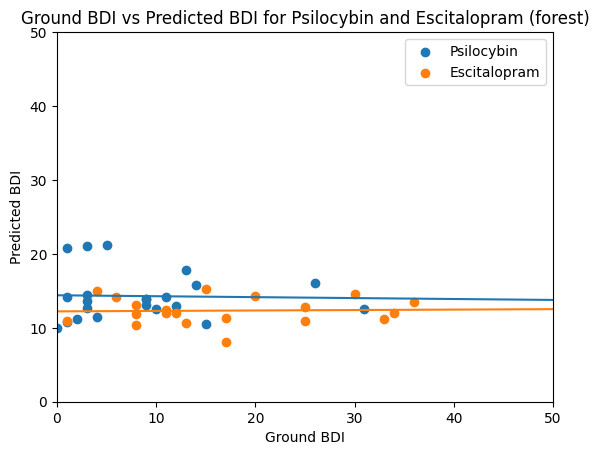

MAE Loss is 8.779761904761905 
R2 score = -0.17205959350284927


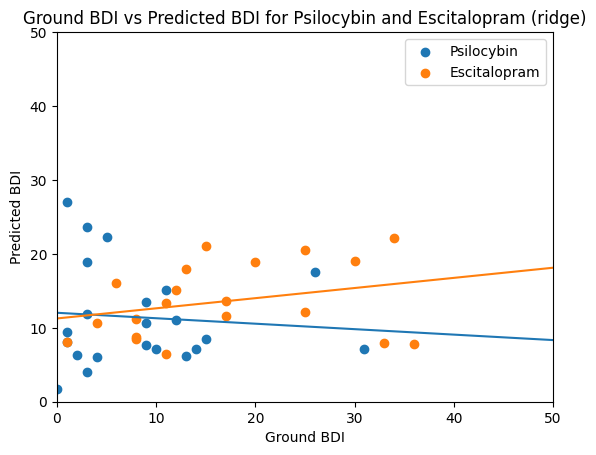

MAE Loss is 7.944496001161378 
R2 score = -0.17335043458446475


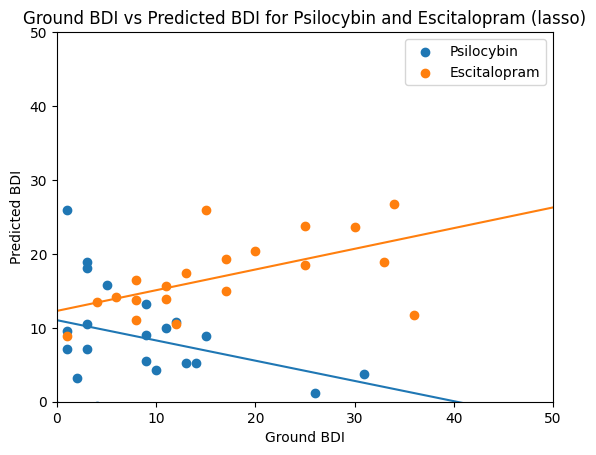

MAE Loss is 7.655739966416333 
R2 score = -0.06187590373207974


In [9]:
plot_ground_vs_pred(forest_ground, forest_predicted, forest_data_labels, mode='forest')
print(f'MAE Loss is {forest_loss.item()} ')
print(f'R2 score = {forest_r2}')

plot_ground_vs_pred(ridge_ground, ridge_predicted, ridge_data_labels, mode='ridge')
print(f'MAE Loss is {ridge_loss.item()} ')
print(f'R2 score = {ridge_r2}')

plot_ground_vs_pred(lasso_ground, lasso_predicted, lasso_data_labels, mode='lasso')
print(f'MAE Loss is {lasso_loss.item()} ')
print(f'R2 score = {lasso_r2}')


In [6]:
forest_ground, forest_predicted, forest_data_labels, forest_loss, forest_r2 = compute_regression(model_type='random_forest', use_graph=False)
ridge_ground, ridge_predicted, ridge_data_labels, ridge_loss, ridge_r2 = compute_regression(model_type='ridge', use_graph=False)
lasso_ground, lasso_predicted, lasso_data_labels, lasso_loss, lasso_r2 = compute_regression(model_type='lasso', use_graph=False)

Training started.


100%|██████████| 42/42 [00:57<00:00,  1.38s/it]


Training complete.
Training started.


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]


Training complete.
Training started.


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]

Training complete.


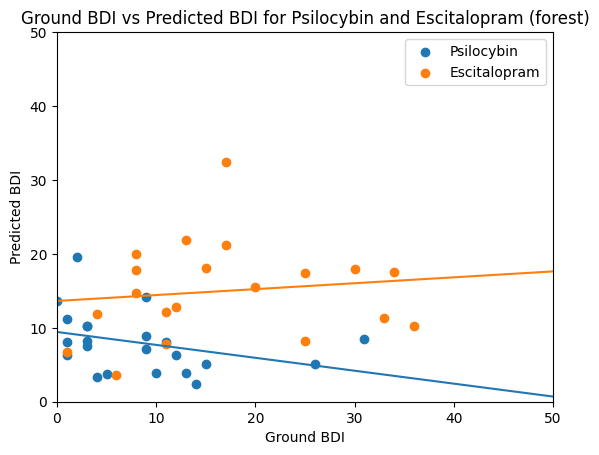

MAE Loss is 8.611835128495843 
R2 score = -0.15365743043014612


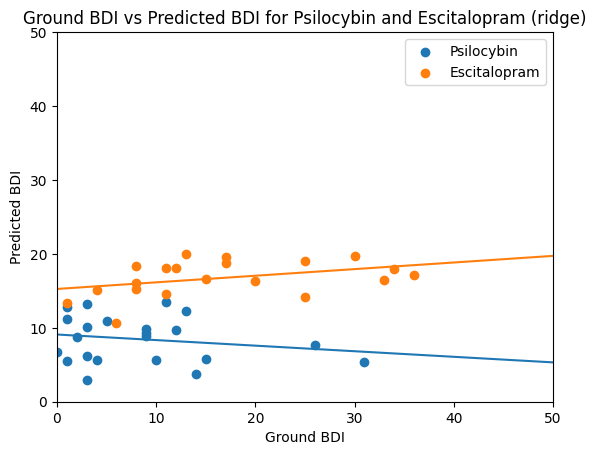

MAE Loss is 7.348320631397881 
R2 score = 0.13802436917094674


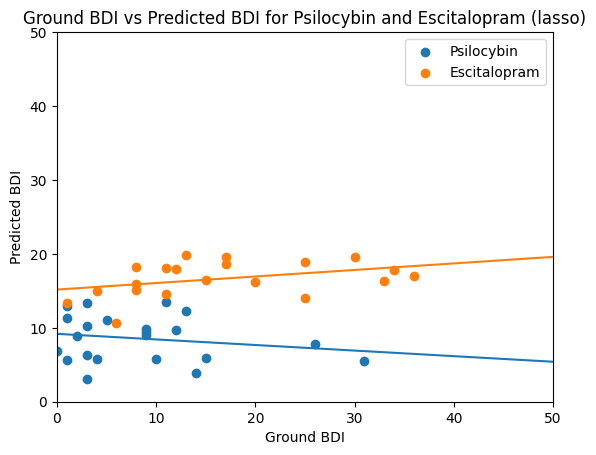

MAE Loss is 7.348903777197795 
R2 score = 0.13779410975028894


In [7]:
plot_ground_vs_pred(forest_ground, forest_predicted, forest_data_labels, mode='forest')
print(f'MAE Loss is {forest_loss.item()} ')
print(f'R2 score = {forest_r2}')

plot_ground_vs_pred(ridge_ground, ridge_predicted, ridge_data_labels, mode='ridge')
print(f'MAE Loss is {ridge_loss.item()} ')
print(f'R2 score = {ridge_r2}')

plot_ground_vs_pred(lasso_ground, lasso_predicted, lasso_data_labels, mode='lasso')
print(f'MAE Loss is {lasso_loss.item()} ')
print(f'R2 score = {lasso_r2}')


In [4]:
forest_ground, forest_predicted, forest_data_labels, forest_loss, forest_r2 = compute_regression(model_type='random_forest', mode='psilo_aal_before')
ridge_ground, ridge_predicted, ridge_data_labels, ridge_loss, ridge_r2 = compute_regression(model_type='ridge', mode='psilo_aal_before')
lasso_ground, lasso_predicted, lasso_data_labels, lasso_loss, lasso_r2 = compute_regression(model_type='lasso', mode='psilo_aal_before')

Training started.


100%|██████████| 42/42 [03:35<00:00,  5.14s/it]


Training complete.
Training started.


100%|██████████| 42/42 [01:11<00:00,  1.70s/it]


Training complete.
Training started.


100%|██████████| 42/42 [01:12<00:00,  1.72s/it]

Training complete.


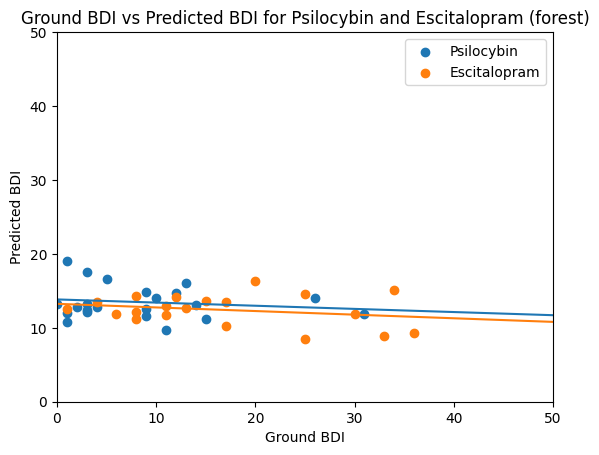

MAE Loss is 8.603809523809524 
R2 score = -0.172434030104601


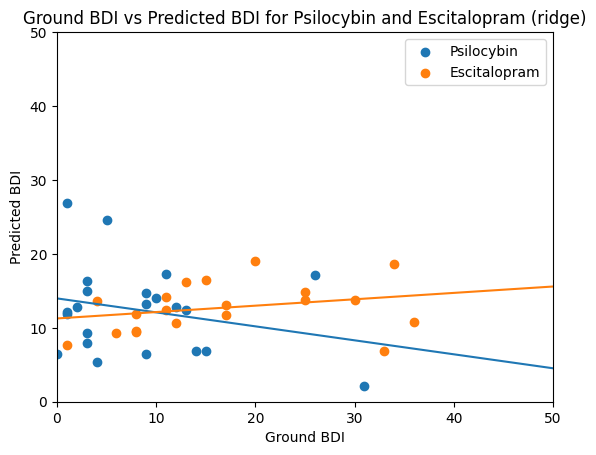

MAE Loss is 8.354269694811123 
R2 score = -0.2527600536016896


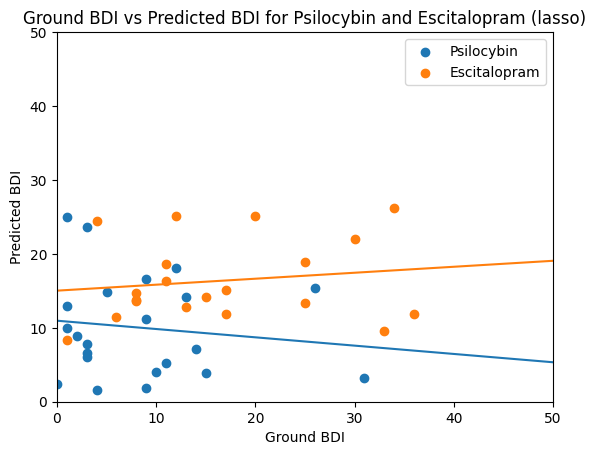

MAE Loss is 8.633834770325494 
R2 score = -0.2045643103856254


In [5]:
plot_ground_vs_pred(forest_ground, forest_predicted, forest_data_labels, mode='forest')
print(f'MAE Loss is {forest_loss.item()} ')
print(f'R2 score = {forest_r2}')

plot_ground_vs_pred(ridge_ground, ridge_predicted, ridge_data_labels, mode='ridge')
print(f'MAE Loss is {ridge_loss.item()} ')
print(f'R2 score = {ridge_r2}')

plot_ground_vs_pred(lasso_ground, lasso_predicted, lasso_data_labels, mode='lasso')
print(f'MAE Loss is {lasso_loss.item()} ')
print(f'R2 score = {lasso_r2}')


In [ ]:
forest_ground, forest_predicted, forest_data_labels = compute_regression(model_type='random_forest', leave_one_out=False)
ridge_ground, ridge_predicted, ridge_data_labels = compute_regression(model_type='ridge', leave_one_out=False)
lasso_ground, lasso_predicted, lasso_data_labels = compute_regression(model_type='lasso',leave_one_out=False)

In [ ]:
plot_ground_vs_pred(forest_ground, forest_predicted, forest_data_labels, mode='forest')
plot_ground_vs_pred(ridge_ground, ridge_predicted, ridge_data_labels, mode='ridge')
plot_ground_vs_pred(lasso_ground, lasso_predicted, lasso_data_labels, mode='lasso')